# Data summary

DATASET:

https://archive.ics.uci.edu/dataset/222/bank+marketing

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.


## bank client data
age

job : type of job

marital : marital status


education

default: has credit in default?

balance: average yearly balance, in euros

housing: has housing loan?

loan: has personal loan?

## related with the last contact of the current campaign:

contact: contact communication type

day: last contact day of the month
  
month: last contact month of year

duration: last contact duration, in seconds

## other attributes:

campaign: number of contacts performed during this campaign and for this client

pdays: number of days that passed by after the client was last contacted from a previous campaign (-1 means client was not previously contacted)

previous: number of contacts performed before this campaign and for this client

poutcome: outcome of the previous marketing campaign

Output variable (desired target):
y - has the client subscribed a term deposit? ("yes","no")


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, average_precision_score, roc_curve, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import RandomizedSearchCV
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.metrics import AUC, Precision, Recall

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Visualization**

In [8]:
df_bank_org = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/bank-additional-full.csv", sep=';')

df_bank_org.sample(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
29197,39,admin.,single,high.school,no,no,no,cellular,apr,fri,...,1,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,no
14957,24,management,married,basic.9y,no,no,no,telephone,jul,wed,...,11,999,0,nonexistent,1.4,93.918,-42.7,4.957,5228.1,no
21646,29,management,single,university.degree,no,yes,no,cellular,aug,tue,...,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,no
21268,44,blue-collar,married,basic.4y,no,yes,no,cellular,aug,mon,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,no
1547,34,blue-collar,married,basic.9y,no,no,no,telephone,may,thu,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
40938,51,housemaid,married,basic.4y,no,no,no,cellular,oct,tue,...,2,999,2,failure,-1.1,94.601,-49.5,0.982,4963.6,no
25269,30,management,married,university.degree,no,no,yes,cellular,nov,tue,...,2,999,1,failure,-0.1,93.200,-42.0,4.153,5195.8,no
6915,40,technician,married,basic.9y,no,yes,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
7437,43,blue-collar,divorced,basic.4y,unknown,yes,no,telephone,may,fri,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.864,5191.0,yes
30899,29,admin.,single,university.degree,no,yes,no,cellular,may,tue,...,1,999,0,nonexistent,-1.8,92.893,-46.2,1.344,5099.1,no


Splitting data set to train and test sets

In [9]:
df_bank, df_bank_test = train_test_split(df_bank_org, test_size=0.2, random_state=42)
df_bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
12556,40,blue-collar,married,basic.9y,unknown,yes,no,telephone,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,no
35451,31,admin.,married,university.degree,no,no,no,cellular,may,mon,...,4,999,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,no
30592,59,retired,married,basic.4y,no,no,no,cellular,may,mon,...,6,999,1,failure,-1.8,92.893,-46.2,1.354,5099.1,no
17914,43,housemaid,divorced,basic.9y,no,yes,no,cellular,jul,tue,...,5,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,no
3315,39,admin.,single,high.school,unknown,no,no,telephone,may,thu,...,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no


In [10]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32950 entries, 12556 to 15795
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             32950 non-null  int64  
 1   job             32950 non-null  object 
 2   marital         32950 non-null  object 
 3   education       32950 non-null  object 
 4   default         32950 non-null  object 
 5   housing         32950 non-null  object 
 6   loan            32950 non-null  object 
 7   contact         32950 non-null  object 
 8   month           32950 non-null  object 
 9   day_of_week     32950 non-null  object 
 10  duration        32950 non-null  int64  
 11  campaign        32950 non-null  int64  
 12  pdays           32950 non-null  int64  
 13  previous        32950 non-null  int64  
 14  poutcome        32950 non-null  object 
 15  emp.var.rate    32950 non-null  float64
 16  cons.price.idx  32950 non-null  float64
 17  cons.conf.idx   32950 non-n

In [11]:
df_bank.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [12]:
for col in df_bank.columns:
  print(col)
  print(df_bank[col].value_counts())

age
31    1551
32    1508
33    1476
36    1443
30    1391
      ... 
89       2
91       2
98       2
95       1
87       1
Name: age, Length: 77, dtype: int64
job
admin.           8328
blue-collar      7439
technician       5352
services         3212
management       2310
retired          1363
self-employed    1153
entrepreneur     1145
housemaid         867
unemployed        798
student           721
unknown           262
Name: job, dtype: int64
marital
married     19823
single       9333
divorced     3733
unknown        61
Name: marital, dtype: int64
education
university.degree      9750
high.school            7614
basic.9y               4808
professional.course    4176
basic.4y               3338
basic.6y               1852
unknown                1399
illiterate               13
Name: education, dtype: int64
default
no         26090
unknown     6857
yes            3
Name: default, dtype: int64
housing
yes        17257
no         14882
unknown      811
Name: housing, dtype: int64
l

In [13]:
df_bank.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000
mean,40.017420,257.746313,2.572959,962.745341,0.172989,0.083105,93.576835,-40.514574,3.622698,5167.094049
std,10.435842,259.459863,2.778138,186.248245,0.492992,1.570011,0.579157,4.622683,1.733735,72.354625
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,179.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,318.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [14]:
# !pip install pandas_profiling

In [15]:
# from pandas_profiling import ProfileReport

# report = ProfileReport(df_bank)
# report.to_file('report_bank.html')

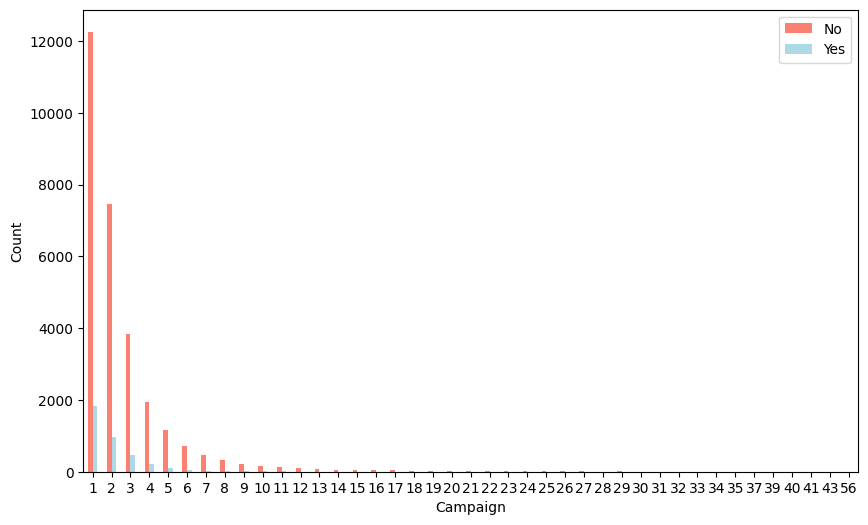

In [16]:
pd.crosstab(df_bank['campaign'], df_bank['y']).plot(kind="bar", figsize=(10,6), color=["salmon","lightblue"])
plt.xlabel("Campaign")
plt.ylabel("Count")
plt.legend(["No", "Yes"])
plt.xticks(rotation=0);

1. Nie ma znaczenia [campaign] - liczba kontaktów do klienta w ramach tej kampanii.

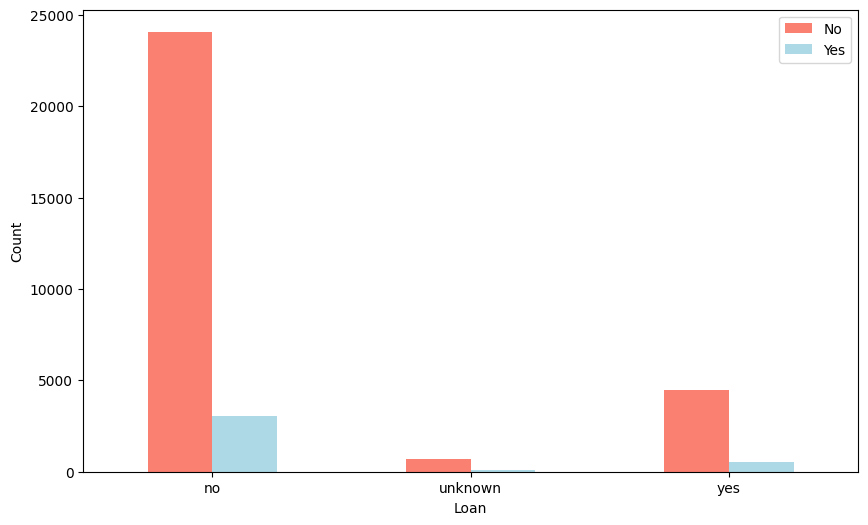

In [17]:
pd.crosstab(df_bank['loan'], df_bank['y']).plot(kind="bar", figsize=(10,6), color=["salmon","lightblue"])
plt.xlabel("Loan")
plt.ylabel("Count")
plt.legend(["No", "Yes"])
plt.xticks(rotation=0);

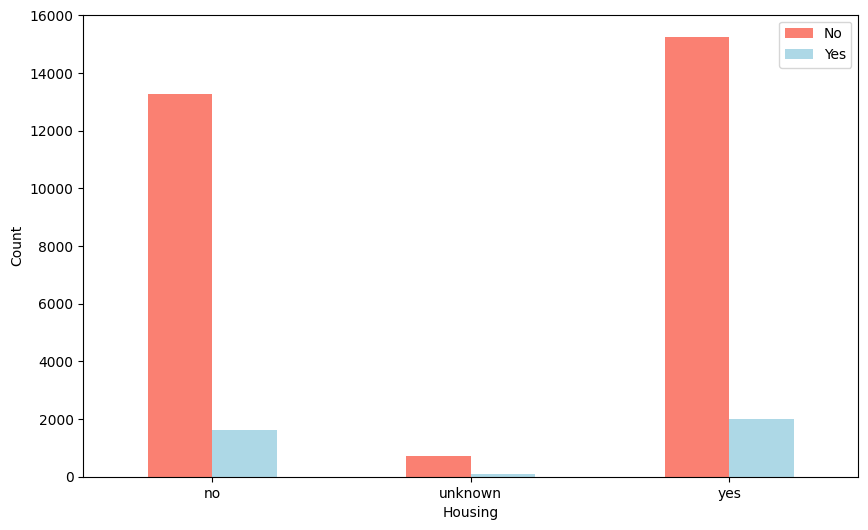

In [18]:
pd.crosstab(df_bank['housing'], df_bank['y']).plot(kind="bar", figsize=(10,6), color=["salmon","lightblue"])
plt.xlabel("Housing")
plt.ylabel("Count")
plt.legend(["No", "Yes"])
plt.xticks(rotation=0);

2. Nie ma znaczenia [housing] - czy ma kredyt mieszkaniowy i [loan] - czy ma pożyczkę osobistą.

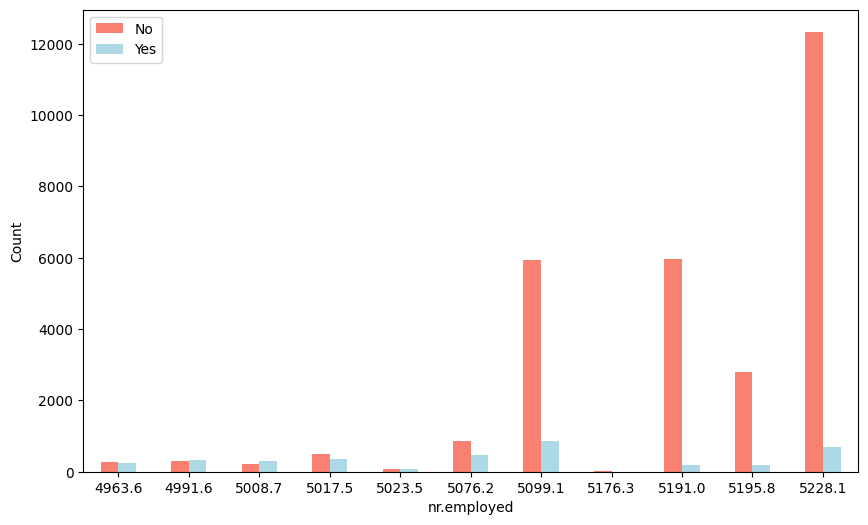

In [19]:
pd.crosstab(df_bank['nr.employed'], df_bank['y']).plot(kind="bar", figsize=(10,6), color=["salmon","lightblue"])
plt.xlabel("nr.employed")
plt.ylabel("Count")
plt.legend(["No", "Yes"])
plt.xticks(rotation=0);

3. Wpływ będzie miało [nr.employed] - liczba pracowników - im mniejsza tym klient chętniej się zgadza.

<Axes: xlabel='euribor3m', ylabel='y'>

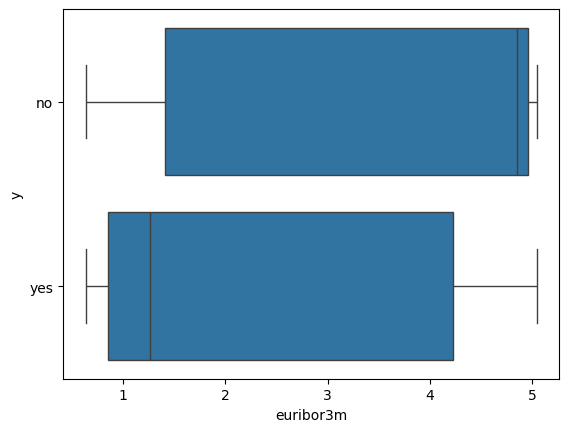

In [20]:
sns.boxplot(x="euribor3m", y="y",data=df_bank)

4. [euribor3m] - stopa euribor 3-miesięczna - wskaźnik dzienny. Im mniejsza stopa tym większe prawdopodobieństwo akceptacji.

<Axes: xlabel='duration', ylabel='y'>

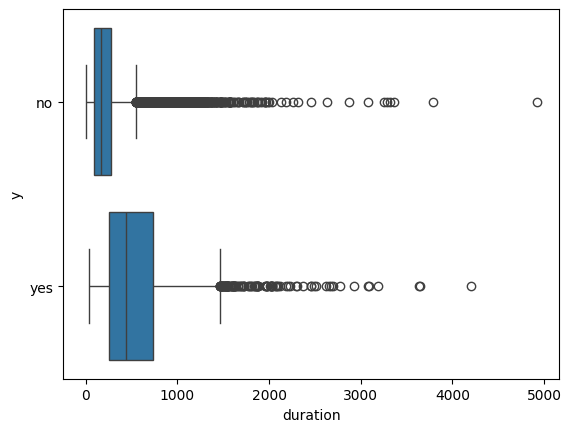

In [21]:
sns.boxplot(x="duration", y="y",data=df_bank)


5. [duration] Im dłuższy czas rozmowy z klientem tym większe prawdopodobieństwo, że klient zaakaceptuje ofertę.

Jednak możemy stwierdzić, że to dłuższy czas rozmowy wynika z akceptacji oferty a nie odwrotnie.
Nie jest to żaden wyznacznik, który pomoże nam określić czy warto do danego klienta zadzwonić, ponieważ najpierw dzwonimy, a potem otrzymujemy informacje ile rozmowa trwała. ([duraion] -> do usunięcia)

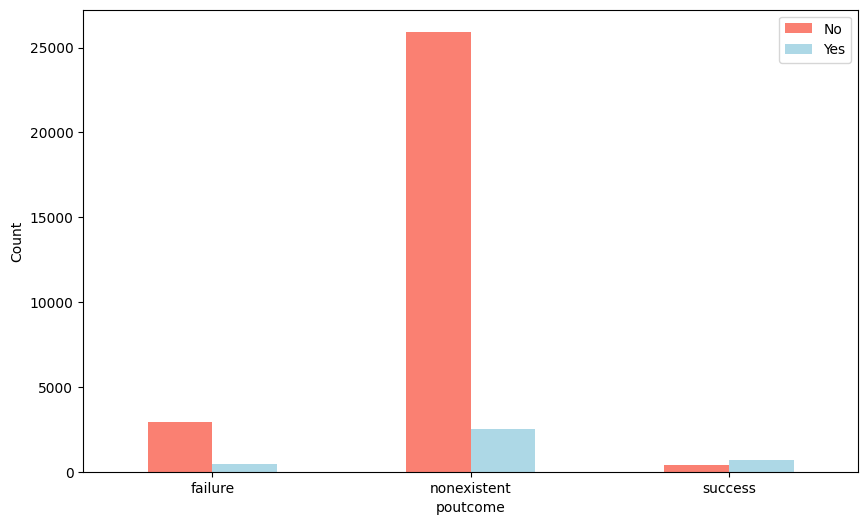

In [22]:
pd.crosstab(df_bank['poutcome'], df_bank['y']).plot(kind="bar", figsize=(10,6), color=["salmon","lightblue"])
plt.xlabel("poutcome")
plt.ylabel("Count")
plt.legend(["No", "Yes"])
plt.xticks(rotation=0);

6. [poutcome] Jeśli poprzednio klient zaakceptował ofertę, to jest większe prawdopodobieństwo, że teraz też zaakceptuje, niż gdyby wcześniej nie zaakceptował.

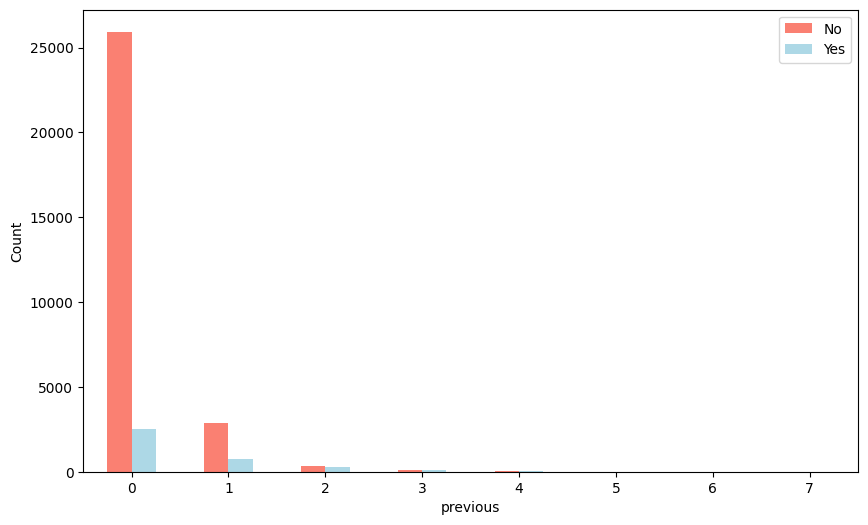

In [23]:
pd.crosstab(df_bank['previous'], df_bank['y']).plot(kind="bar", figsize=(10,6), color=["salmon","lightblue"])
plt.xlabel("previous")
plt.ylabel("Count")
plt.legend(["No", "Yes"])
plt.xticks(rotation=0);

7. [previous] Jeśli wcześniej kontaktowano się z klientem to istnieje większe prawdopodobieństwo, że zaakceptuje ofertę.

In [24]:
# plt.clf()
# sns.pairplot(df_bank, hue="y")
# plt.show()

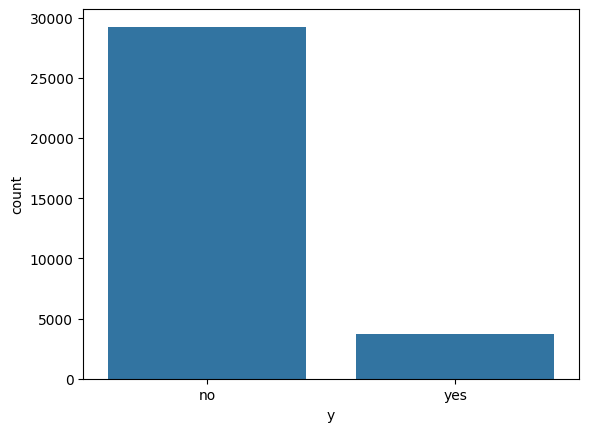

In [25]:
plt.clf
sns.countplot(x=df_bank["y"])
plt.show()

- large dataset imbalance

**Hypotheses:**

1. It doesn't matter [campaign] - the number of contacts to the customer within this campaign.
2. It doesn't matter [housing] - whether he has a housing loan and [loan] - whether he has a personal loan.
3. [employed number] will have an influence - the number of employees - the smaller it is, the more willing the client is to agree.
4. [euribor3m] - 3-month euribor rate - daily rate. The lower the rate, the greater the probability of acceptance.
%high correlation [euribor3m] with [nr.employed]
5. [duration] -> not related to the task
6. [poutcome] If the customer previously accepted the offer, it is more likely that he will accept it now than if he had not accepted it before.
7. [previous] If the customer has been contacted before, we can assume that he will accept the offer.

(correlation [housing] with [loan])

(inversely correlated [previous] with [euribor3m] and [nr.employed])


I remove the 'duration' column --> the decision affects its length, not the other way around

In [26]:
df_bank = df_bank.drop('duration', axis=1)
df_bank_test = df_bank_test.drop('duration', axis=1)

In [27]:
df_bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
12556,40,blue-collar,married,basic.9y,unknown,yes,no,telephone,jul,mon,2,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,no
35451,31,admin.,married,university.degree,no,no,no,cellular,may,mon,4,999,0,nonexistent,-1.8,92.893,-46.2,1.244,5099.1,no
30592,59,retired,married,basic.4y,no,no,no,cellular,may,mon,6,999,1,failure,-1.8,92.893,-46.2,1.354,5099.1,no
17914,43,housemaid,divorced,basic.9y,no,yes,no,cellular,jul,tue,5,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,no
3315,39,admin.,single,high.school,unknown,no,no,telephone,may,thu,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no


In [28]:
df_bank.y = df_bank.y.replace({'yes':1, 'no':0})
df_bank_test.y = df_bank_test.y.replace({'yes':1, 'no':0})

<ipython-input-29-00ab5b4eb170>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_bank.corr()


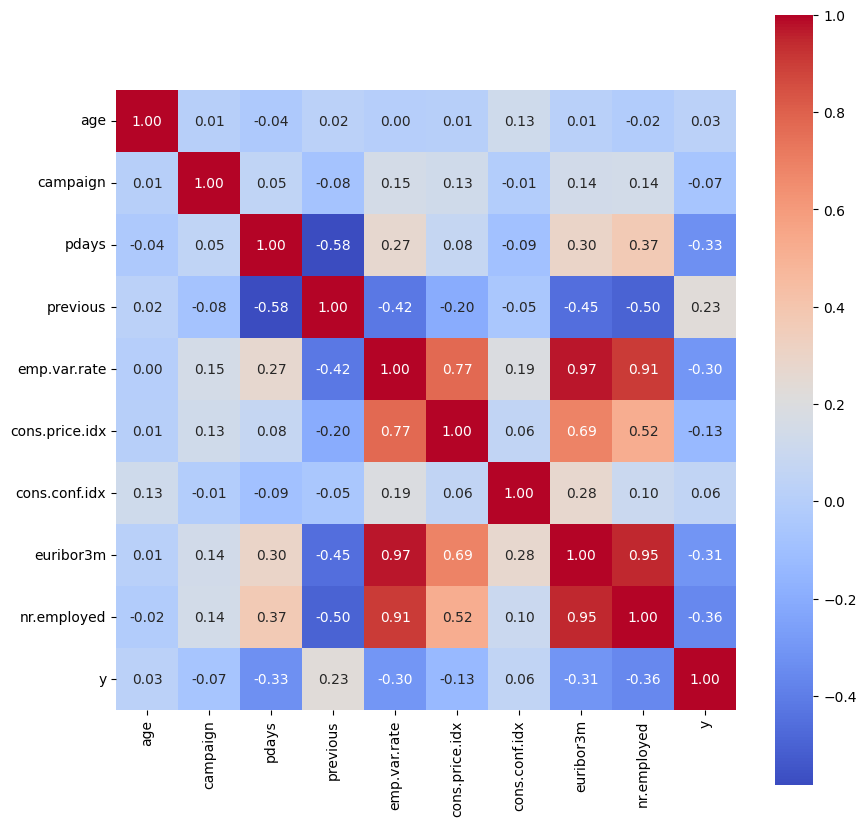

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))
corr_matrix = df_bank.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, ax=ax)
plt.show()

In [30]:
# for col in df_bank.columns:
#   plt.clf()
#   sns.countplot(data=df_bank, x=col, hue="y")
#   plt.xticks(rotation=90)
#   plt.show()

#**Data Selection**

W kilku kolumnach mamy 'unknown', ale nie jest tych danych bardzo dużo więc decyduję się na ich usunięcie.

In [31]:
for col in df_bank.columns:
  df_bank = df_bank[(df_bank[col] != 'unknown')]
  df_bank_test = df_bank_test[(df_bank_test[col] != 'unknown')]


Usuwam również 'illiterate' z kol 'education' (uznaję to za błąd)


In [32]:
df_bank[df_bank["education"] == 'illiterate'].groupby(["y"]).count()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,,,,,,,,,,,
0,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5
1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


In [33]:
df_bank['education'] = df_bank['education'][df_bank['education'] != 'illiterate']
df_bank_test['education'] = df_bank_test['education'][df_bank_test['education'] != 'illiterate']

In [34]:
for col in df_bank.columns:
  print(col)
  print(df_bank[col].value_counts())

age
31    1312
32    1279
33    1213
30    1164
36    1132
      ... 
91       2
17       2
95       1
86       1
87       1
Name: age, Length: 75, dtype: int64
job
admin.           6978
blue-collar      4552
technician       4348
services         2323
management       1838
retired           957
self-employed     880
entrepreneur      851
unemployed        580
housemaid         568
student           506
Name: job, dtype: int64
marital
married     13863
single       7634
divorced     2884
Name: marital, dtype: int64
education
university.degree      8361
high.school            6177
professional.course    3435
basic.9y               3378
basic.4y               1897
basic.6y               1126
Name: education, dtype: int64
default
no     24378
yes        3
Name: default, dtype: int64
housing
yes    13232
no     11149
Name: housing, dtype: int64
loan
no     20578
yes     3803
Name: loan, dtype: int64
contact
cellular     16349
telephone     8032
Name: contact, dtype: int64
month
may    7755

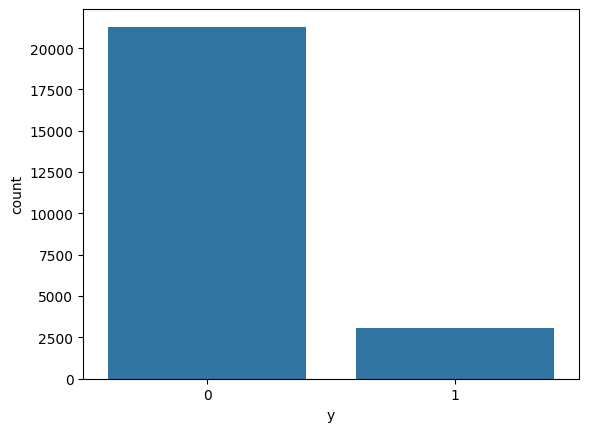

In [35]:
plt.clf
sns.countplot(x=df_bank["y"])
plt.show()

**Categorical to numeric**

In [41]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

df_cat = df_bank[['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']]
df_num = df_bank[['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']]

encoder.fit(df_cat)
cat_enc = encoder.transform(df_cat).toarray()
df_cat_enc = pd.DataFrame(cat_enc)


df_cat_test = df_bank_test[['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']]
df_num_test = df_bank_test[['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']]
cat_enc_test = encoder.transform(df_cat_test).toarray()
df_cat_enc_test = pd.DataFrame(cat_enc_test)

In [42]:
df_num.reset_index(drop=True, inplace=True)
df_cat_enc.reset_index(drop=True, inplace=True)

X_train = pd.concat([df_num, df_cat_enc], axis=1).to_numpy()
Y_train = df_bank['y'].to_numpy()


df_num_test.reset_index(drop=True, inplace=True)
df_cat_enc_test.reset_index(drop=True, inplace=True)

X_test = pd.concat([df_num_test, df_cat_enc_test], axis=1).to_numpy()
Y_test = df_bank_test['y'].to_numpy()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

In [43]:
df_num.shape

(24381, 9)

In [44]:
df_cat_enc.shape

(24381, 47)

In [45]:
X_train.shape

(24381, 56)

In [46]:
df_num_test.shape

(6107, 9)

In [47]:
df_cat_enc_test.shape

(6107, 47)

In [48]:
X_test.shape

(6107, 56)

#**Balancing the dataset**

In [49]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_smote, Y_smote = smote.fit_resample(X_train_norm, Y_train)
print(X_smote.shape)
print(f"y = 0, number of samples: {np.sum(Y_smote == 0)}")
print(f"y = 1, number of samples: {np.sum(Y_smote == 1)}")

(42594, 56)
y = 0, number of samples: 21297
y = 1, number of samples: 21297


#**LogisticRegression**

In [50]:
models = []
auc_= []
f1_ = []
accuracy_ = []
precision_ = []
recall_ = []
y_pred_proba_ = []

AUC=0.7952467149045326
f1=0.46388888888888885
accuracy=0.8103815293925004
precision=0.36173285198555954
recall=0.6464516129032258


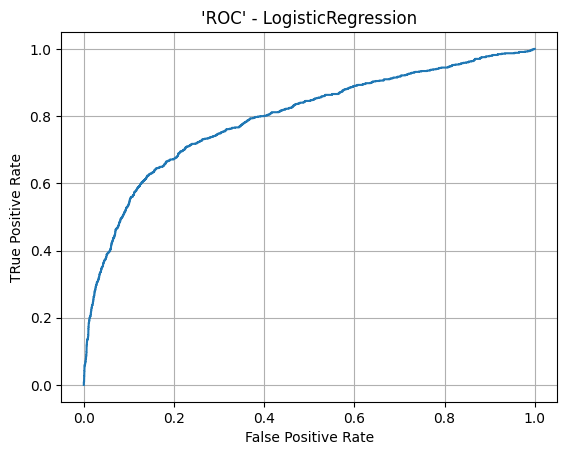

In [51]:
model_logreg = LogisticRegression()
model_logreg.fit(X_smote, Y_smote)

Y_pred = model_logreg.predict(X_test_norm)

Y_pred_proba = model_logreg.predict_proba(X_test_norm)


#ROC and AUC
fpr, tpr, threshold = roc_curve(Y_test, Y_pred_proba[:,1])
plt.plot(fpr, tpr)
plt.ylabel("TRue Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("'ROC' - LogisticRegression")
plt.grid()

auc = roc_auc_score(Y_test, Y_pred_proba[:,1])
print(f"AUC={auc}")
f1 = f1_score(Y_test, Y_pred)
print(f"f1={f1}")
accuracy = accuracy_score(Y_test, Y_pred)
print(f"accuracy={accuracy}")
precision = precision_score(Y_test, Y_pred)
print(f"precision={precision}")
recall = recall_score(Y_test, Y_pred)
print(f"recall={recall}")

models.append('LogisticRegression')
auc_.append(auc)
f1_.append(f1)
accuracy_.append(accuracy)
precision_.append(precision)
recall_.append(recall)
y_pred_proba_.append(Y_pred_proba[:,1])


#**DecisionTree**

In [52]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV


# model_dt = DecisionTreeClassifier()

# param_grid = {'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 30]}

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(model_dt, param_grid, cv=cv)
# grid_search.fit(X_smote, Y_smote)

# print(f"best_max_depth = {grid_search.best_params_}")
# print(f"best_accuracy = {grid_search.best_score_}")


AUC=0.6193960990247561
f1=0.37894736842105264
accuracy=0.8454232847551989
precision=0.3865771812080537
recall=0.3716129032258065


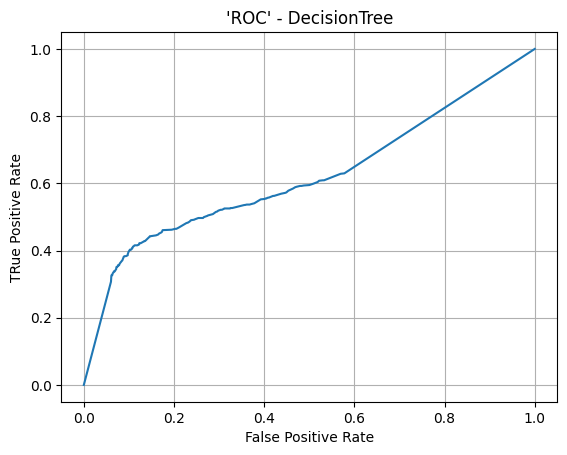

In [53]:
model_dt = DecisionTreeClassifier(max_depth=19, random_state=42)
model_dt.fit(X_smote, Y_smote)

Y_pred = model_dt.predict(X_test_norm)

Y_pred_proba = model_dt.predict_proba(X_test_norm)


#ROC and AUC
fpr, tpr, threshold = roc_curve(Y_test, Y_pred_proba[:,1])
plt.plot(fpr, tpr)
plt.ylabel("TRue Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("'ROC' - DecisionTree")
plt.grid()

auc = roc_auc_score(Y_test, Y_pred_proba[:,1])
print(f"AUC={auc}")
f1 = f1_score(Y_test, Y_pred)
print(f"f1={f1}")
accuracy = accuracy_score(Y_test, Y_pred)
print(f"accuracy={accuracy}")
precision = precision_score(Y_test, Y_pred)
print(f"precision={precision}")
recall = recall_score(Y_test, Y_pred)
print(f"recall={recall}")

models.append('DT')
auc_.append(auc)
f1_.append(f1)
accuracy_.append(accuracy)
precision_.append(precision)
recall_.append(recall)
y_pred_proba_.append(Y_pred_proba[:,1])

#**KNN**

In [54]:
# model_knn = KNeighborsClassifier()

# param_grid = {'n_neighbors':range(2,10), 'metric': ["euclidean", "manhattan", "cosine"]}

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(model_knn, param_grid, cv=cv)
# grid_search.fit(X_smote, Y_smote)

# print(f"best_max_depth = {grid_search.best_params_}")
# print(f"best_accuracy = {grid_search.best_score_}")

# best_max_depth = {'metric': 'manhattan', 'n_neighbors': 3}
# best_accuracy = 0.894210356028888


AUC=0.7035097887375069
f1=0.3845327604726101
accuracy=0.8123464876371377
precision=0.32934682612695493
recall=0.4619354838709677


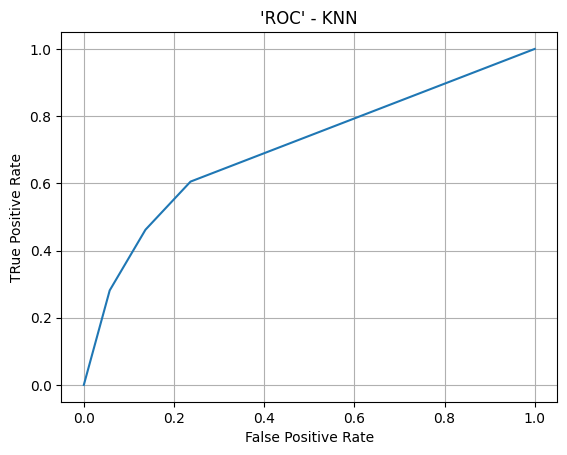

In [55]:
model_knn = KNeighborsClassifier(n_neighbors=3, metric='manhattan')
model_knn.fit(X_smote, Y_smote)

Y_pred = model_knn.predict(X_test_norm)

Y_pred_proba = model_knn.predict_proba(X_test_norm)


#ROC and AUC
fpr, tpr, threshold = roc_curve(Y_test, Y_pred_proba[:,1])
plt.plot(fpr, tpr)
plt.ylabel("TRue Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("'ROC' - KNN")
plt.grid()

auc = roc_auc_score(Y_test, Y_pred_proba[:,1])
print(f"AUC={auc}")
f1 = f1_score(Y_test, Y_pred)
print(f"f1={f1}")
accuracy = accuracy_score(Y_test, Y_pred)
print(f"accuracy={accuracy}")
precision = precision_score(Y_test, Y_pred)
print(f"precision={precision}")
recall = recall_score(Y_test, Y_pred)
print(f"recall={recall}")

models.append('KNN')
auc_.append(auc)
f1_.append(f1)
accuracy_.append(accuracy)
precision_.append(precision)
recall_.append(recall)
y_pred_proba_.append(Y_pred_proba[:,1])

#**Neural Networks**

In [56]:
X_train, Y_train, X_val, Y_val = train_test_split(X_smote, Y_smote)

In [57]:
# model = keras.models.Sequential()
# EarlyStop = EarlyStopping(monitor='val_loss',
#                           patience=3,
#                           verbose=1)

# ModelCheck = ModelCheckpoint(filepath='najlepszy_model_nn.h5',
#                              monitor='val_loss',
#                              save_best_only=True)

# def create_model(n_hidden=1, n_neurons=30):
#     model = keras.models.Sequential()
#     for _ in range(n_hidden):
#         model.add(keras.layers.Dense(n_neurons, activation='relu'))
#         model.add(keras.layers.Dropout(0.2))
#     model.add(keras.layers.Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model

# param_grid = {
#     "n_hidden": [1, 2, 3],
#     "n_neurons": np.arange(30, 50),
# }

# model = KerasClassifier(build_fn=create_model)
# rnd_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
# rnd_search.fit(X_smote, Y_smote,
#                epochs=100,
#                validation_split=0.3,
#                callbacks=[EarlyStop])
# print(f"best_params: {rnd_search.best_params_}")
# print(f"best_accuracy = {rnd_search.best_score_}")

In [58]:
# print(f"best_params: {rnd_search.best_params_}")
# print(f"best_accuracy = {rnd_search.best_score_}")


# best_params: {'n_hidden': 1, 'n_neurons': 48}
# best_accuracy = 0.6356414159138998

Epoch 1/100
932/932 [==============================] - 4s 3ms/step - loss: 0.4785 - accuracy: 0.7909 - auc: 0.7866 - precision: 0.6930 - recall: 0.4812 - val_loss: 0.9175 - val_accuracy: 0.5320 - val_auc: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.5320
Epoch 2/100
 89/932 [=>............................] - ETA: 1s - loss: 0.4427 - accuracy: 0.8178 - auc: 0.8266 - precision: 0.7563 - recall: 0.5692

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


932/932 [==============================] - 2s 2ms/step - loss: 0.4472 - accuracy: 0.8098 - auc: 0.8163 - precision: 0.7257 - recall: 0.5372 - val_loss: 0.8726 - val_accuracy: 0.5615 - val_auc: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.5615
Epoch 3/100
932/932 [==============================] - 2s 3ms/step - loss: 0.4380 - accuracy: 0.8141 - auc: 0.8259 - precision: 0.7345 - recall: 0.5470 - val_loss: 0.8405 - val_accuracy: 0.6019 - val_auc: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.6019
Epoch 4/100
932/932 [==============================] - 3s 3ms/step - loss: 0.4330 - accuracy: 0.8160 - auc: 0.8316 - precision: 0.7339 - recall: 0.5585 - val_loss: 0.8508 - val_accuracy: 0.5912 - val_auc: 0.0000e+00 - val_precision: 1.0000 - val_recall: 0.5912
Epoch 5/100
932/932 [==============================] - 3s 3ms/step - loss: 0.4281 - accuracy: 0.8187 - auc: 0.8353 - precision: 0.7412 - recall: 0.5613 - val_loss: 0.8518 - val_accuracy: 0.5750 - val_auc: 0.0000e+00 - val_precisi

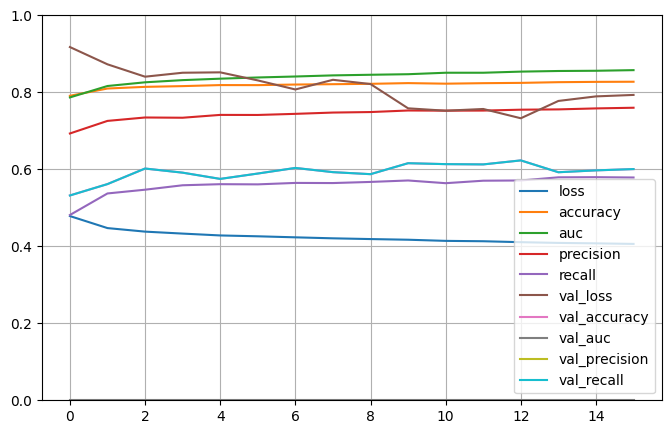

191/191 [==============================] - 0s 1ms/step
AUC=0.7898305654525757
accuracy=0.8647453784942627
precision=0.4653061330318451
recall=0.44129031896591187


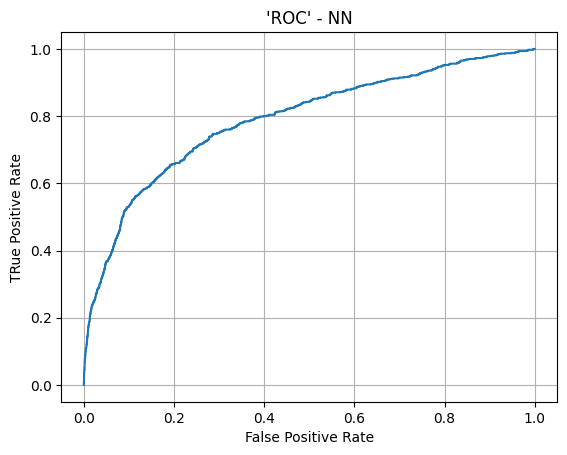

In [59]:
n_neurons = 48
model = keras.models.Sequential()
model.add(keras.layers.Dense(n_neurons, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', AUC(), Precision(), Recall()])

EarlyStop = EarlyStopping(monitor='val_loss',
                          patience=3,
                          verbose=1)

ModelCheck = ModelCheckpoint(filepath='najlepszy_model_nn.h5',
                             monitor='val_loss',
                             save_best_only=True)

history = model.fit(X_smote, Y_smote,
                    epochs=100,
                    validation_split=0.3,
                    callbacks = [EarlyStop, ModelCheck]
                   )

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()


metrics = model.evaluate(X_test_norm, Y_test, return_dict=True)
Y_pred_nn = model.predict(X_test_norm)
Y_pred_nn

models.append('NN')
auc_.append(metrics['auc'])
accuracy_.append(metrics['accuracy'])
precision_.append(metrics['precision'])
recall_.append(metrics['recall'])
y_pred_proba_.append(Y_pred_nn)


print(f"AUC={metrics['auc']}")
print(f"accuracy={metrics['accuracy']}")
print(f"precision={metrics['precision']}")
print(f"recall={metrics['recall']}")

#ROC and AUC
fpr, tpr, threshold = roc_curve(Y_test, Y_pred_nn)
plt.plot(fpr, tpr)
plt.ylabel("TRue Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("'ROC' - NN")
plt.grid()

In [60]:
metrics

{'loss': 0.3426900804042816,
 'accuracy': 0.8647453784942627,
 'auc': 0.7898305654525757,
 'precision': 0.4653061330318451,
 'recall': 0.44129031896591187}

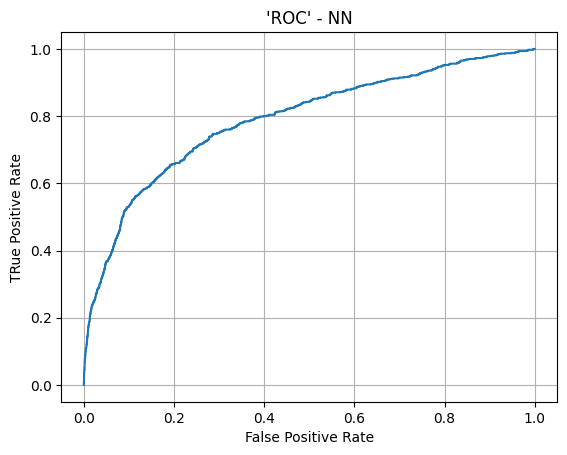

In [61]:
#ROC and AUC
fpr, tpr, threshold = roc_curve(Y_test, Y_pred_nn)
plt.plot(fpr, tpr)
plt.ylabel("TRue Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("'ROC' - NN")
plt.grid()

#**Selecting fewer features using LDA**


In [62]:
model_LDA = LinearDiscriminantAnalysis()
model_LDA.fit(X_smote, Y_smote)

print(X_smote.shape)
X_lda = model_LDA.transform(X_smote)
X_lda_test = model_LDA.transform(X_test_norm)
print(X_lda.shape)
X_lda

(42594, 56)
(42594, 1)


array([[-0.15699425],
       [-0.8045525 ],
       [-1.08937143],
       ...,
       [ 1.74863611],
       [-1.10499036],
       [ 0.7889737 ]])

AUC=0.7944909614500398
f1=0.4544650751547303
accuracy=0.7979367938431309
precision=0.3456624075319435
recall=0.6632258064516129


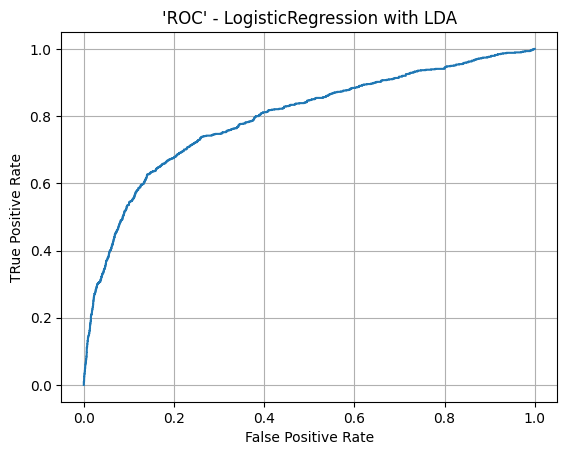

In [63]:
model_logreg_lda = LogisticRegression()
model_logreg_lda.fit(X_lda, Y_smote)

Y_pred = model_logreg_lda.predict(X_lda_test)

Y_pred_proba = model_logreg_lda.predict_proba(X_lda_test)


#ROC and AUC
fpr, tpr, threshold = roc_curve(Y_test, Y_pred_proba[:,1])
plt.plot(fpr, tpr)
plt.ylabel("TRue Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("'ROC' - LogisticRegression with LDA")
plt.grid()

auc = roc_auc_score(Y_test, Y_pred_proba[:,1])
print(f"AUC={auc}")
f1 = f1_score(Y_test, Y_pred)
print(f"f1={f1}")
accuracy = accuracy_score(Y_test, Y_pred)
print(f"accuracy={accuracy}")
precision = precision_score(Y_test, Y_pred)
print(f"precision={precision}")
recall = recall_score(Y_test, Y_pred)
print(f"recall={recall}")

models.append('LogisticRegression with LDA')
auc_.append(auc)
f1_.append(f1)
accuracy_.append(accuracy)
precision_.append(precision)
recall_.append(recall)
y_pred_proba_.append(Y_pred_proba[:,1])


In [64]:
# model_knn = KNeighborsClassifier()

# param_grid = {'n_neighbors':range(2,10), 'metric': ["euclidean", "manhattan", "cosine"]}

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# grid_search = GridSearchCV(model_knn, param_grid, cv=cv)
# grid_search.fit(X_lda, Y_smote)

# print(f"best_max_depth = {grid_search.best_params_}")
# print(f"best_accuracy = {grid_search.best_score_}")

# best_max_depth = {'metric': 'cosine', 'n_neighbors': 5}
# best_accuracy = 0.7497769208951078

AUC=0.7406714178544637
f1=0.46238532110091746
accuracy=0.8080890781070902
precision=0.35871886120996443
recall=0.6503225806451612


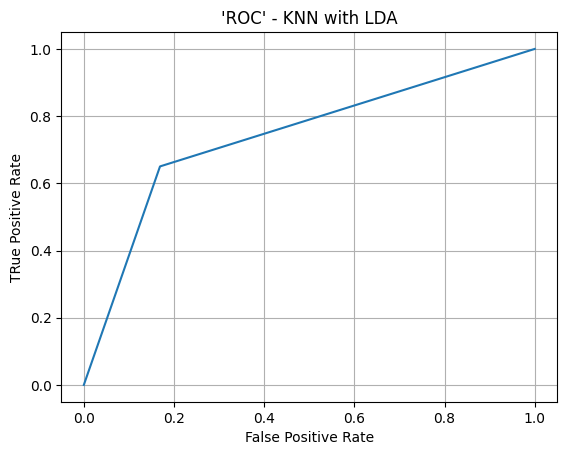

In [65]:
model_knn = KNeighborsClassifier(n_neighbors=5, metric='cosine')
model_knn.fit(X_lda, Y_smote)

Y_pred = model_knn.predict(X_lda_test)
Y_pred_proba = model_knn.predict_proba(X_lda_test)


#ROC and AUC
fpr, tpr, threshold = roc_curve(Y_test, Y_pred_proba[:,1])
plt.plot(fpr, tpr)
plt.ylabel("TRue Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("'ROC' - KNN with LDA")
plt.grid()

auc = roc_auc_score(Y_test, Y_pred_proba[:,1])
print(f"AUC={auc}")
f1 = f1_score(Y_test, Y_pred)
print(f"f1={f1}")
accuracy = accuracy_score(Y_test, Y_pred)
print(f"accuracy={accuracy}")
precision = precision_score(Y_test, Y_pred)
print(f"precision={precision}")
recall = recall_score(Y_test, Y_pred)
print(f"recall={recall}")

models.append('KNN with LDA')
auc_.append(auc)
f1_.append(f1)
accuracy_.append(accuracy)
precision_.append(precision)
recall_.append(recall)
y_pred_proba_.append(Y_pred_proba[:,1])

In [66]:
# model = keras.models.Sequential()
# EarlyStop = EarlyStopping(monitor='val_loss',
#                           patience=3,               # patience - po ile epokach sie zatrzyma jesli model sie nie bedzie poprawial
#                           verbose=1)

# ModelCheck = ModelCheckpoint(filepath='najlepszy_model_nn.h5',
#                              monitor='val_loss',
#                              save_best_only=True)

# def create_model(n_hidden=1, n_neurons=30):
#     model = keras.models.Sequential()
#     for _ in range(n_hidden):
#         model.add(keras.layers.Dense(n_neurons, activation='relu'))
#         model.add(keras.layers.Dropout(0.2))
#     model.add(keras.layers.Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model

# param_grid = {
#     "n_hidden": [1, 2, 3],
#     "n_neurons": np.arange(30, 50),
# }

# model = KerasClassifier(build_fn=create_model)
# rnd_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
# rnd_search.fit(X_lda, Y_smote,
#                epochs=100,
#                validation_split=0.3,
#                callbacks=[EarlyStop])
# print(f"best_params: {rnd_search.best_params_}")
# print(f"best_accuracy = {rnd_search.best_score_}")

In [67]:
# print(f"best_params: {rnd_search.best_params_}")
# print(f"best_accuracy = {rnd_search.best_score_}")

# best_params: {'n_hidden': 3, 'n_neurons': 45}
# best_accuracy = 0.6324364940325419

Epoch 1/100
932/932 [==============================] - 5s 3ms/step - loss: 0.4893 - accuracy: 0.7857 - auc_1: 0.7786 - precision_1: 0.6966 - recall_1: 0.4431 - val_loss: 0.8134 - val_accuracy: 0.5798 - val_auc_1: 0.0000e+00 - val_precision_1: 1.0000 - val_recall_1: 0.5798
Epoch 2/100
 60/932 [>.............................] - ETA: 2s - loss: 0.4489 - accuracy: 0.8068 - auc_1: 0.8209 - precision_1: 0.7237 - recall_1: 0.5591

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


932/932 [==============================] - 4s 5ms/step - loss: 0.4561 - accuracy: 0.8064 - auc_1: 0.8085 - precision_1: 0.7196 - recall_1: 0.5282 - val_loss: 0.7979 - val_accuracy: 0.6057 - val_auc_1: 0.0000e+00 - val_precision_1: 1.0000 - val_recall_1: 0.6057
Epoch 3/100
932/932 [==============================] - 3s 3ms/step - loss: 0.4472 - accuracy: 0.8124 - auc_1: 0.8181 - precision_1: 0.7253 - recall_1: 0.5529 - val_loss: 0.7836 - val_accuracy: 0.5986 - val_auc_1: 0.0000e+00 - val_precision_1: 1.0000 - val_recall_1: 0.5986
Epoch 4/100
932/932 [==============================] - 3s 3ms/step - loss: 0.4410 - accuracy: 0.8148 - auc_1: 0.8241 - precision_1: 0.7301 - recall_1: 0.5578 - val_loss: 0.8395 - val_accuracy: 0.5781 - val_auc_1: 0.0000e+00 - val_precision_1: 1.0000 - val_recall_1: 0.5781
Epoch 5/100
932/932 [==============================] - 3s 3ms/step - loss: 0.4354 - accuracy: 0.8166 - auc_1: 0.8300 - precision_1: 0.7354 - recall_1: 0.5595 - val_loss: 0.7277 - val_accuracy: 

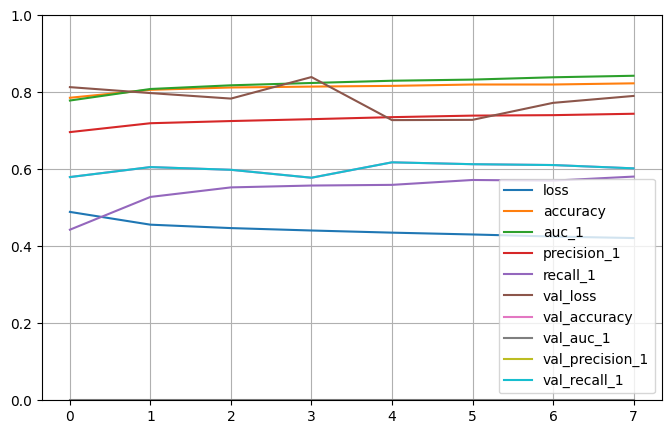

191/191 [==============================] - 0s 1ms/step
AUC=0.7940283417701721
accuracy=0.8632716536521912
precision=0.46305418014526367
recall=0.48516130447387695


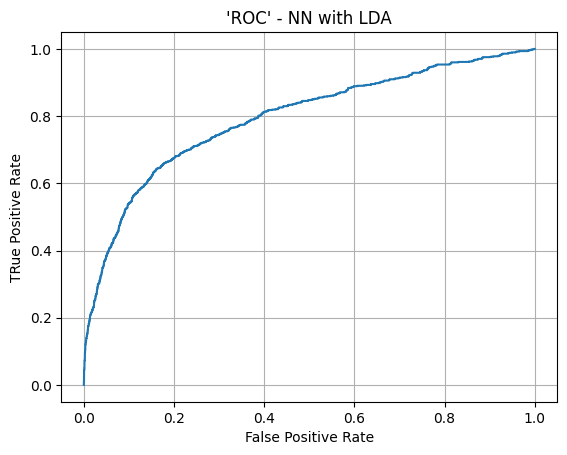

In [68]:
n_neurons = 45
n_hidden=3
model = keras.models.Sequential()
for n in range(n_hidden):
  model.add(keras.layers.Dense(n_neurons, activation='relu'))
  model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', AUC(), Precision(), Recall()])

EarlyStop = EarlyStopping(monitor='val_loss',
                          patience=3,
                          verbose=1)

ModelCheck = ModelCheckpoint(filepath='najlepszy_model_nn.h5',
                             monitor='val_loss',
                             save_best_only=True)

history = model.fit(X_smote, Y_smote,
                    epochs=100,
                    validation_split=0.3,
                    callbacks = [EarlyStop, ModelCheck]
                   )

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()


metrics = model.evaluate(X_test_norm, Y_test, return_dict=True)
Y_pred_nn = model.predict(X_test_norm)
Y_pred_nn

models.append('NN with LDA')
auc_.append(metrics['auc_1'])
accuracy_.append(metrics['accuracy'])
precision_.append(metrics['precision_1'])
recall_.append(metrics['recall_1'])
y_pred_proba_.append(Y_pred_nn)


print(f"AUC={metrics['auc_1']}")
print(f"accuracy={metrics['accuracy']}")
print(f"precision={metrics['precision_1']}")
print(f"recall={metrics['recall_1']}")

#ROC i AUC wykres
fpr, tpr, threshold = roc_curve(Y_test, Y_pred_nn)
plt.plot(fpr, tpr)
plt.ylabel("TRue Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("'ROC' - NN with LDA")
plt.grid()

#**Models Comparison**

In [69]:
wyniki_df = pd.DataFrame({
    'AUC' : auc_,
    'accuracy' : accuracy_,
    'precision' : precision_,
    'recall' : recall_,
})
wyniki_df.index = models
wyniki_df

,AUC,accuracy,precision,recall
LogisticRegression,0.795247,0.810382,0.361733,0.646452
DT,0.619396,0.845423,0.386577,0.371613
KNN,0.703510,0.812346,0.329347,0.461935
NN,0.789831,0.864745,0.465306,0.441290
LogisticRegression with LDA,0.794491,0.797937,0.345662,0.663226
KNN with LDA,0.740671,0.808089,0.358719,0.650323
NN with LDA,0.794028,0.863272,0.463054,0.485161


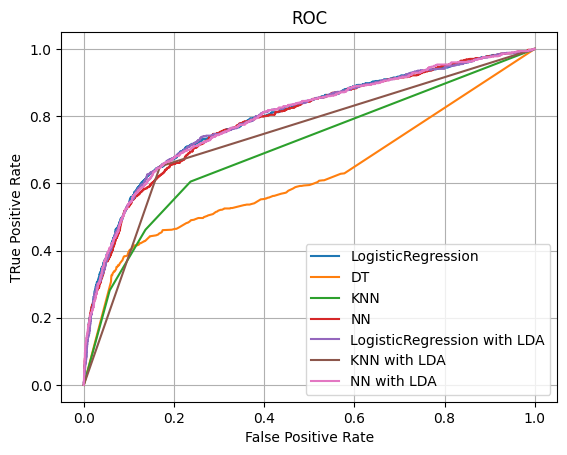

In [70]:
for model in models:
  fpr, tpr, threshold = roc_curve(Y_test, y_pred_proba_[models.index(model)])
  plt.plot(fpr, tpr)
  plt.ylabel("TRue Positive Rate")
  plt.xlabel("False Positive Rate")
  plt.title("ROC")
  plt.grid()
  plt.legend(models)

Model with the best result is Logistic Regression and Neural Networks.

Decission Tree and K-Near Neighbours models don't give good results.